# Perbandingan Algoritma Feature Selection

## Problem Statement

Sebuah dataset biasanya memiliki banyak fitur yang mendukung suatu nilai dapat berubah, seperti dalam contoh prediksi harga rumah, fitur ukuran rumah dan jumlah kamar merupakan faktor signifikan yang menjadikan harga rumah berbeda. Tetapi dalam data tersebut bisa saja ada fitur yang memiliki relevansi yang rendah dalam mendukung harga rumah tersebut seperti warna cat.

Fitur yang memiliki relenvansi yang rendah bisa berdampak pada akurasi model machine learning yang dibangun. Oleh karena itu, algoritma feature selection hadir untuk memilih fitur mana saja yang dianggap penting dalam memprediksi suatu nilai.

Project ini akan membahas terkait perbandingan beberapa algoritma feature selection dari dataset wine, algoritma tersebut diantaranya:
1. FCMIM - Fast Conditional Mutual Information Maximization
2. MI - Mutual Information
3. Chi2 - Chi-Square
4. RFE - Recursive Feature Elimination
5. SKB - SelectKBest
6. GA - Genetic Algorithm

Dalam hal ini, SVM classifier akan digunakan sebagai algoritma klasifikasi.

Paper Reference:
- [A comprehensive survey on feature selection in the various ﬁelds of machine learning](https://doi.org/10.1007/s10489-021-02550-9)
- [Feature selection based on mutual information with correlation
coeﬃcient](https://doi.org/10.1007/s10489-021-02524-x)
- [Feature selection for multi-label classiﬁcation by maximizing
full-dimensional conditional mutual information](https://doi.org/10.1007/s10489-020-01822-0)
- [Feature selection using an improved Chi-square for Arabic text
classification](https://doi.org/10.1016/j.jksuci.2018.05.010)

In [1]:
!pip install scikit-learn
!pip install skfeature-chappers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.3 MB/s eta 0:00:00


Dalam project ini setiap algoritma FS akan memilih fitur mana saja yang relevan dan penting berdasarkan jumlah fitur yang akan terus meningkat setiap iterasi.

In [2]:
import numpy as np
import time
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, VarianceThreshold, RFE
from skfeature.function.information_theoretical_based import CMIM

# Memuat dataset wine
data = load_wine()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_features = X.shape[1]

results = {method: [] for method in ['FCMIM', 'MI', 'Chi2', 'RFE', 'SKB']}

def record_time(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    return result, end_time - start_time

for method in ['FCMIM', 'MI', 'Chi2', 'RFE', 'SKB']:
    for num_features in range(1, max_features + 1):
        # Memilih metode feature selection
        if method == 'FCMIM':
            scores, duration = record_time(CMIM.cmim, X_train, y_train)
            selected_features = np.argsort(scores)[-num_features:]
        elif method == 'MI':
            mi, duration = record_time(mutual_info_classif, X_train, y_train)
            selected_features = np.argsort(mi)[-num_features:]
        elif method == 'Chi2':
            chi2_selector = SelectKBest(chi2, k=num_features)
            _, duration = record_time(chi2_selector.fit, X_train, y_train)
            selected_features = chi2_selector.get_support(indices=True)
        elif method == 'RFE':
            rfe_selector = RFE(estimator=SVC(kernel="linear"), n_features_to_select=num_features)
            _, duration = record_time(rfe_selector.fit, X_train, y_train)
            selected_features = rfe_selector.get_support(indices=True)
        elif method == 'SKB':
            skb_selector = SelectKBest(k=num_features)
            _, duration = record_time(skb_selector.fit, X_train, y_train)
            selected_features = skb_selector.get_support(indices=True)

        # Memilih fitur yang dipilih
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]

        svm = SVC(kernel='linear', random_state=42)
        svm.fit(X_train_selected, y_train)

        y_pred = svm.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[method].append({
            'num_features': num_features,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'time': duration,
            'selected_features': [data.feature_names[i] for i in selected_features]
        })

# Menampilkan hasil akurasi, precision, recall, f1, waktu eksekusi, dan fitur yang dipilih untuk setiap metode feature selection
for method in ['FCMIM', 'MI', 'Chi2', 'RFE', 'SKB']:
    print(f'{method}:')
    for result in results[method]:
        print(f"  Jumlah Fitur: {result['num_features']}")
        print(f"    Accuracy: {result['accuracy']:.2f}")
        print(f"    Precision: {result['precision']:.2f}")
        print(f"    Recall: {result['recall']:.2f}")
        print(f"    F1 Score: {result['f1']:.2f}")
        print(f"    Execution Time: {result['time']:.4f} seconds")
        print("    Selected Features:")
        for feature in result['selected_features']:
            print(f'      - {feature}')
        print()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


FCMIM:
  Jumlah Fitur: 1
    Accuracy: 0.44
    Precision: 0.32
    Recall: 0.40
    F1 Score: 0.35
    Execution Time: 0.2162 seconds
    Selected Features:
      - alcalinity_of_ash

  Jumlah Fitur: 2
    Accuracy: 0.56
    Precision: 0.42
    Recall: 0.50
    F1 Score: 0.44
    Execution Time: 0.2127 seconds
    Selected Features:
      - magnesium
      - alcalinity_of_ash

  Jumlah Fitur: 3
    Accuracy: 0.81
    Precision: 0.82
    Recall: 0.82
    F1 Score: 0.82
    Execution Time: 0.2577 seconds
    Selected Features:
      - color_intensity
      - magnesium
      - alcalinity_of_ash

  Jumlah Fitur: 4
    Accuracy: 0.83
    Precision: 0.85
    Recall: 0.84
    F1 Score: 0.84
    Execution Time: 0.1487 seconds
    Selected Features:
      - hue
      - color_intensity
      - magnesium
      - alcalinity_of_ash

  Jumlah Fitur: 5
    Accuracy: 0.89
    Precision: 0.90
    Recall: 0.90
    F1 Score: 0.90
    Execution Time: 0.2266 seconds
    Selected Features:
      - total_ph

## Analisis Perbandingan

1. FCMIM:
- Meningkatkan jumlah fitur dari 1 hingga 7 adanya peningkatan akurasi dari 0,44 menjadi 0,98, dan precision, recall, serta F1 score juga meningkat dengan konsisten.
- Pada 7 fitur, akurasi mencapai 0,98, yang tetap konstan meski fitur ditambahkan hingga 13.
- FCMIM cenderung membutuhkan fitur lebih banyak untuk mencapai performa optimal, dengan waktu eksekusi yang relatif stabil di sekitar 0,05 detik.

2. MI (Mutual Information):

- MI menunjukkan performa yang sangat baik bahkan dengan fitur yang lebih sedikit. Pada 6 fitur, mencapai akurasi maksimal 1,00 dengan precision, recall, dan F1 score juga 1,00.
- Akurasi tetap stabil di 1,00 hingga penggunaan 10 fitur, dan mulai menurun sedikit saat fitur ditambahkan hingga 13.
- MI memiliki waktu eksekusi yang cepat, sekitar 0,04 detik, dan secara konsisten mencapai hasil yang sangat baik dengan fitur yang lebih sedikit dibandingkan FCMIM.

3. Chi2:
- Chi2 menunjukkan kinerja yang cukup tinggi, mencapai akurasi 0,98 dengan hanya 3 fitur dan mempertahankan performa tersebut hingga 13 fitur.
- Chi2 memiliki waktu eksekusi tercepat di antara semua metode, sekitar 0,0017 detik, membuatnya sangat efisien meski dengan performa yang sebanding.
- Meskipun efisien, Chi2 mulai menunjukkan sedikit penurunan dalam akurasi di beberapa tahap jika fitur terus ditambahkan.

4. RFE (Recursive Feature Elimination):
- RFE menunjukkan hasil yang baik, mencapai akurasi maksimal 0,96 dengan 5 fitur dan mempertahankannya dengan penambahan fitur lebih banyak.
- Waktu eksekusi RFE lebih lambat dibandingkan metode lain, berkisar antara 0,29 hingga 0,53 detik, menjadikannya metode yang lebih intensif dari segi komputasi.
- RFE membutuhkan lebih sedikit fitur untuk mencapai akurasi tinggi, namun membutuhkan waktu eksekusi yang lebih panjang.

5. SKB (SelectKBest)
- SKB memiliki performa yang cukup baik, dimana pada jumlah fitur ke 5-7 memiliki akurasi 1.0 dengan waktu yang relatif sangat singkat. Hal ini menunjukkan kemampuan SKB dalam memilih fitur yang relevan berdasarkan data.

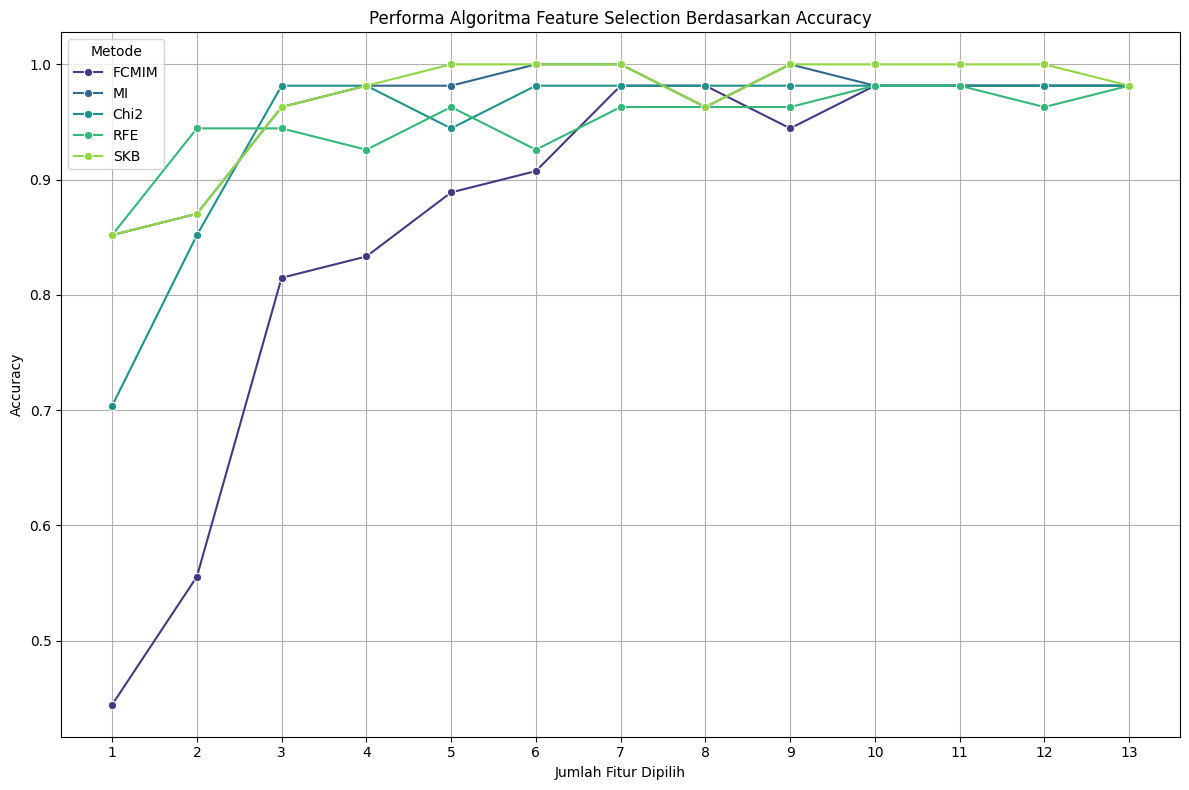

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_accuracy = []

for method, method_results in results.items():
    for result in method_results:
        data_accuracy.append({
            'Method': method,
            'Num Features': result['num_features'],
            'Accuracy': result['accuracy']
        })

df_accuracy = pd.DataFrame(data_accuracy)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_accuracy, x='Num Features', y='Accuracy', hue='Method', marker='o', palette='viridis')
plt.title('Performa Algoritma Feature Selection Berdasarkan Accuracy')
plt.xlabel('Jumlah Fitur Dipilih')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, max_features + 1, 1))
plt.grid(True)
plt.legend(title='Metode')
plt.tight_layout()
plt.show()


## Kesimpulan Sementara

- MI unggul dalam performa dengan fitur lebih sedikit dan efisiensi yang baik.
- Chi2 sangat efisien dari segi waktu eksekusi, namun performanya mulai menurun seiring dengan bertambahnya fitur.
- FCMIM membutuhkan lebih banyak fitur untuk mencapai performa optimal, tetapi konsisten.
- RFE memiliki kinerja yang baik dengan fitur lebih sedikit, namun waktu eksekusi yang lebih lama.
- SKB memiliki performa yang optimal dan waktu eksekusi yang relatif singkat.

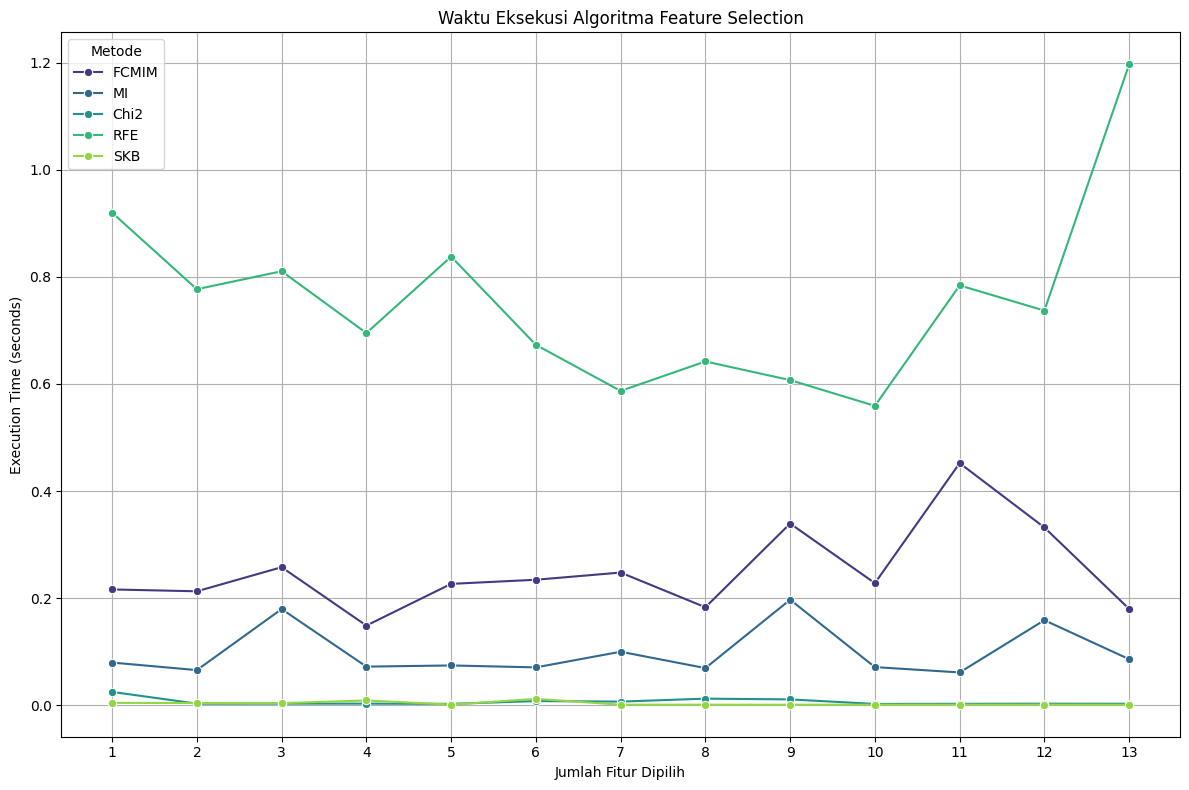

In [4]:
data_execution_time = []

for method, method_results in results.items():
    for result in method_results:
        data_execution_time.append({
            'Method': method,
            'Num Features': result['num_features'],
            'Execution Time': result['time']
        })

df_execution_time = pd.DataFrame(data_execution_time)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_execution_time, x='Num Features', y='Execution Time', hue='Method', marker='o', palette='viridis')
plt.title('Waktu Eksekusi Algoritma Feature Selection')
plt.xlabel('Jumlah Fitur Dipilih')
plt.ylabel('Execution Time (seconds)')
plt.xticks(np.arange(1, max_features + 1, 1))
plt.grid(True)
plt.legend(title='Metode')
plt.tight_layout()
plt.show()


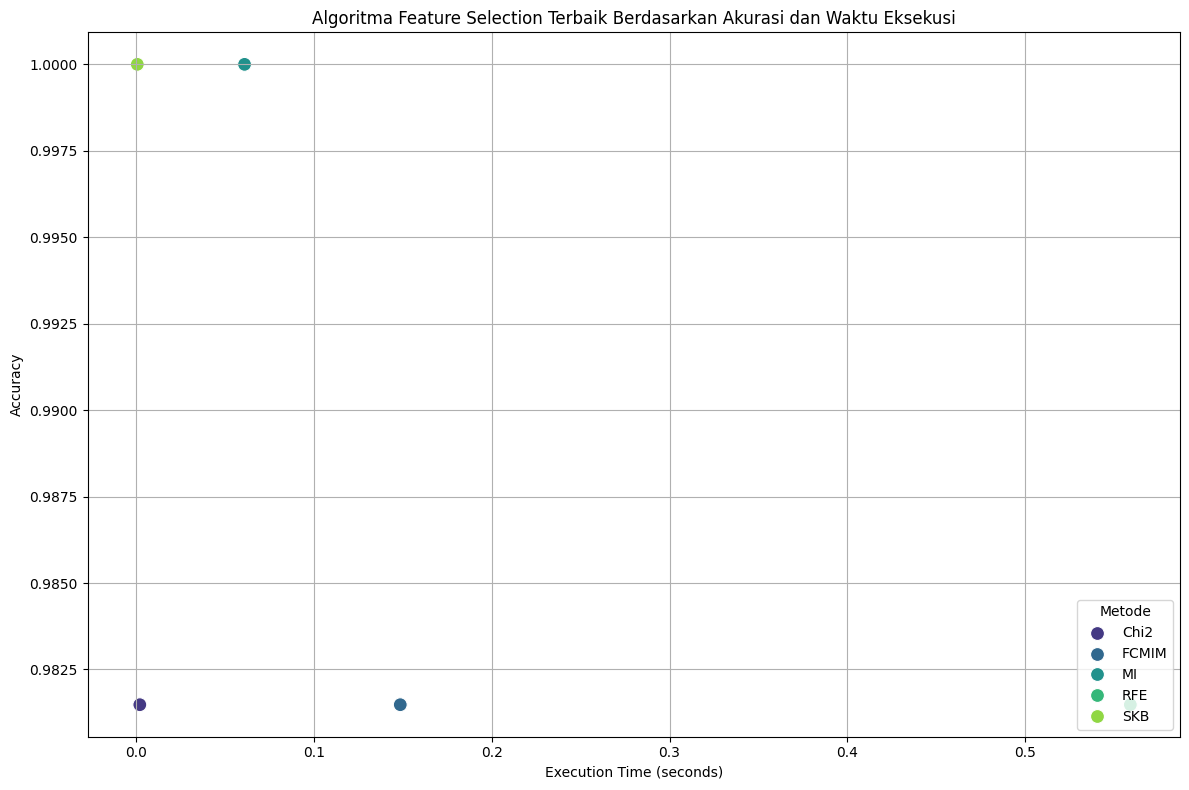

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_combined = []

for method, method_results in results.items():
    for result in method_results:
        data_combined.append({
            'Method': method,
            'Num Features': result['num_features'],
            'Accuracy': result['accuracy'],
            'Execution Time': result['time']
        })

df_combined = pd.DataFrame(data_combined)

best_accuracy = df_combined.groupby('Method')['Accuracy'].max()
best_execution_time = df_combined.groupby('Method')['Execution Time'].min()

best_methods = []
for method in best_accuracy.index:
    best_methods.append({
        'Method': method,
        'Accuracy': best_accuracy[method],
        'Execution Time': best_execution_time[method]
    })

df_best_methods = pd.DataFrame(best_methods)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_best_methods, x='Execution Time', y='Accuracy', hue='Method', s=100, palette='viridis')
plt.title('Algoritma Feature Selection Terbaik Berdasarkan Akurasi dan Waktu Eksekusi')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Metode', loc='lower right')
plt.show()


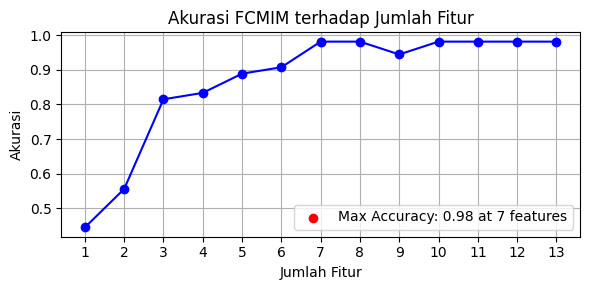

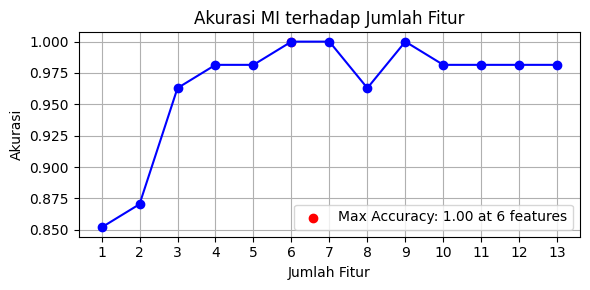

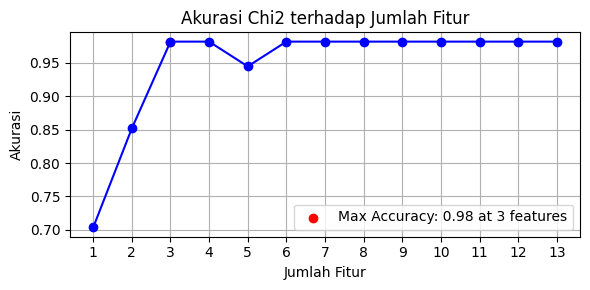

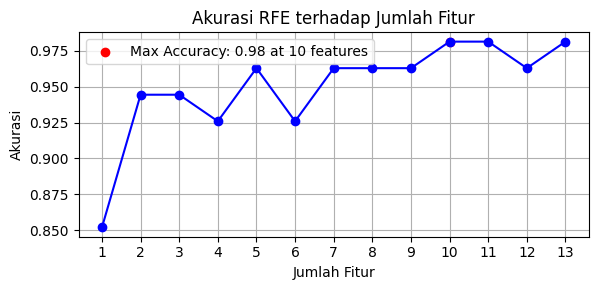

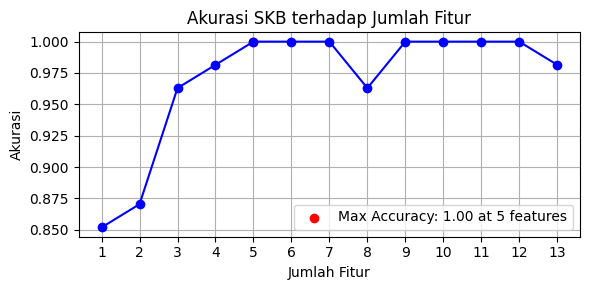

In [10]:
# Plot semua algoritma
for method, method_results in results.items():
    accuracies = []
    num_features = []

    for result in method_results:
        accuracies.append(result['accuracy'])
        num_features.append(result['num_features'])

    # Cari max acc
    max_accuracy_index = np.argmax(accuracies)
    best_accuracy = accuracies[max_accuracy_index]
    best_num_features = num_features[max_accuracy_index]

    plt.figure(figsize=(6, 3))
    plt.plot(num_features, accuracies, marker='o', linestyle='-', color='b')
    plt.scatter(best_num_features, best_accuracy, color='r', label=f'Max Accuracy: {best_accuracy:.2f} at {best_num_features} features')
    plt.title(f'Akurasi {method} terhadap Jumlah Fitur')
    plt.xlabel('Jumlah Fitur')
    plt.ylabel('Akurasi')
    plt.xticks(np.arange(1, max(num_features) + 1, 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Kesimpulan
Algoritma MI dan SKB dapat mencapai akurasi paling tinggi yaitu 100%, sehingga pada kasus ini, SKB lebih unggul karena mendapatkan akurasi pada jumlah 5 fitur saja dengan waktu eksekusi yang relatif singkat.

## Genetic Algorithms

Genetic algorithms termasuk kedalam metaheuristic algorithm. biasanya memiliki waktu eksekusi yang relatif cukup lama, karena dalam prosesnya, algoritma ini akan melakukan iterasi generasi untuk mendapatkan hasil yang paling optimal, oleh karena itu, genetic algorithms diperlakukan berbeda pada kasus ini.

In [8]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


gen	nevals	max	min     	avg     
0  	50    	1  	0.759259	0.905185
1  	38    	1  	0.87037 	0.957407
2  	27    	1  	0.907407	0.976667
3  	27    	1  	0.833333	0.987037
4  	30    	1  	0.944444	0.995185
5  	25    	1  	0.962963	0.995185
6  	23    	1  	0.87037 	0.995926
7  	29    	1  	0.907407	0.994815
8  	26    	1  	0.925926	0.994815
9  	38    	1  	0.925926	0.993704
10 	38    	1  	0.814815	0.993333
11 	20    	1  	0.944444	0.996667
12 	30    	1  	0.962963	0.996667
13 	34    	1  	0.851852	0.991111
14 	27    	1  	0.981481	0.998519
15 	28    	1  	0.944444	0.997407
16 	35    	1  	0.944444	0.992593
17 	30    	1  	0.944444	0.994815
18 	32    	1  	0.962963	0.998148
19 	26    	1  	0.944444	0.996296
20 	30    	1  	0.962963	0.996667
Best Individual: [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Selected Features: ['alcalinity_of_ash', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Best Accuracy: 1.0000


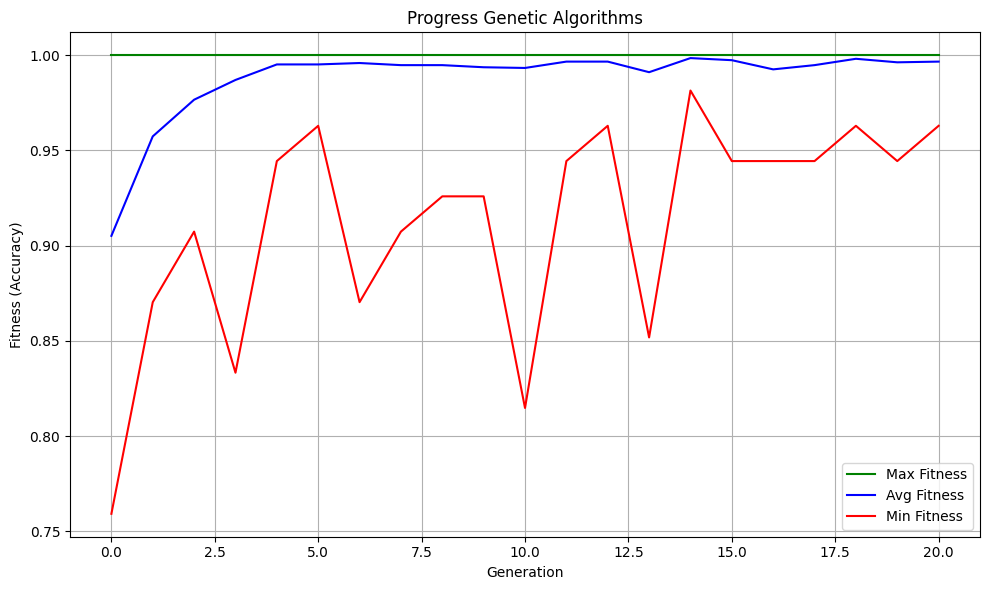

In [9]:
from deap import base, creator, tools, algorithms

NUM_GENERATIONS = 20
POPULATION_SIZE = 50
CX_PROB = 0.5
MUT_PROB = 0.2
NUM_FEATURES = X.shape[1]

def evaluate_fitness(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]

    if len(selected_features) == 0:
        return 0,

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train_selected, y_train)

    y_pred = svm.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=NUM_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def run_ga():
    population = toolbox.population(n=POPULATION_SIZE)

    hall_of_fame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    population, logbook = algorithms.eaSimple(
        population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB,
        ngen=NUM_GENERATIONS, stats=stats,
        halloffame=hall_of_fame, verbose=True
    )

    best_individual = hall_of_fame[0]
    best_accuracy = evaluate_fitness(best_individual)[0]
    selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

    print(f"Best Individual: {best_individual}")
    print(f"Selected Features: {[data.feature_names[i] for i in selected_features]}")
    print(f"Best Accuracy: {best_accuracy:.4f}")

    return logbook, best_individual, best_accuracy

logbook, best_individual, best_accuracy = run_ga()

gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")
min_fitness = logbook.select("min")

plt.figure(figsize=(10, 6))
plt.plot(gen, max_fitness, label="Max Fitness", color="green")
plt.plot(gen, avg_fitness, label="Avg Fitness", color="blue")
plt.plot(gen, min_fitness, label="Min Fitness", color="red")

plt.title("Progress Genetic Algorithms")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()